In [2]:
%matplotlib nbagg
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os
import sys

In [3]:
channel_PIPS_trans = "SARES11-GES1:CH1_VAL_GET/data"           #X-ray TRANS diode to PRIME Keysight (channel 1)
channel_PIPS_fluo = "SARES11-GES1:CH2_VAL_GET/data"            #X-ray FLUO diode to PRIME Keysight (channel 2)

#channel_Izero2 = "SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
#channel_Izero = "SARES11-LSCP10-FNS:CH2:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
#channel_Izero3 = "SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
#channel_Izero4 = "SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)

channel_Izero = "SAROP11-CVME-PBPS2:Lnk9Ch12-DATA-SUM/data"            #Izero diode to Wavedream PBPS117 (Up - PDU)
channel_Izero2 = "SAROP11-CVME-PBPS2:Lnk9Ch13-DATA-SUM/data"           #Izero diode to Wavedream PBPS117 (Down - PDD)
channel_Izero3 = "SAROP11-CVME-PBPS2:Lnk9Ch14-DATA-SUM/data"           #Izero diode to Wavedream PBPS117 (Right - PDR)
channel_Izero4 = "SAROP11-CVME-PBPS2:Lnk9Ch15-DATA-SUM/data"           #Izero diode to Wavedream PBPS117 (Left - PDL)

channel_pulse_ids = "SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)

channel_LaserDiode = "SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
channel_Laser_refDiode = "SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
channel_Laser_diag     = "SLAAR11-LSCP1-FNS:CH4:VAL_GET/data"            #Laser diode on the DIAG table to laser Ioxos

channel_delay = "SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_delay_NPP = "SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS/data"   #Delay in mm from the NPP small stage
channel_LAM_delaystage = "SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
channel_LAM_stepper = "SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
channel_PALM_eTOF = "SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2
channel_PALM_drift = "SAROP11-PALMK118:CH2_VAL_GET/data"               #PALM drift

channel_laser_yaw= "SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"
channel_laser_pitch= "SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS/data"

# testing this palm channel and see what drift it reports 
channel_BAM = "SLAAR11-LTIM01-EVR0:DUMMY_PV9_NBS/data" # SLAAR-GEN:PALM-RAVE CP NMS
#channel_BAM = "SAROP11-PALMK118:CH2_VAL_GET/data" 
#channel_BAM = "S10BC01-DBAM070:EOM1_T1/data"

channel_Events = "SAR-CVME-TIFALL5:EvtSet/data"

In [11]:
def LoadData_YAG(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        
        FEL = BS_file[channel_Events][:,48]
        Laser = BS_file[channel_Events][:,18]
        Darkshot = BS_file[channel_Events][:,21]
        
        index_pump = np.logical_and(FEL, Laser, np.logical_not(Darkshot))
        index_unpump = np.logical_and(np.logical_not(FEL), Laser, np.logical_not(Darkshot))
    
        LaserDiode_pump = BS_file[channel_LaserDiode][:][index_pump]
        LaserDiode_unpump = BS_file[channel_LaserDiode][:][index_unpump]
        LaserRefDiode_pump = BS_file[channel_Laser_refDiode][:][index_pump]
        LaserRefDiode_unpump = BS_file[channel_Laser_refDiode][:][index_unpump]
        
        Izero_pump = BS_file[channel_Izero][:][index_pump]
        Izero_unpump = BS_file[channel_Izero][:][index_unpump]
        PIPS = BS_file[channel_PIPS_trans][:][index_pump]
        
        Delay = BS_file[channel_delay][:][index_unpump]
        #Delay = BS_file[channel_laser_pitch][:][index_unpump]
        
        BAM = BS_file[channel_BAM][:][index_unpump]
        
    return LaserDiode_pump, LaserDiode_unpump, Izero_pump, Izero_unpump, PIPS, LaserRefDiode_pump,LaserRefDiode_unpump,Delay, BAM, pulse_ids

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*2*np.sqrt(np.log(2))/(np.abs(d)))

In [38]:
scan_name ="YAG_FEL0.1_laser11uJ_003"

#scan_name ="Overlap_pitch_ref_008"

DIR = "/sf/alvra/data/p17805/res/scan_data/" + scan_name + "/"
#DIR = "/sf/alvra/data/p17803/res/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17805/res/scan_info/"



In [41]:
!ls -la -rt $DIR


!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 591234
-rw-r--r--.  1 39147 p17805 19409248 May 22 10:11 YAG_FEL0.1_laser11uJ_003_step0000.h5
drwxrwsr-x. 15 39147 p17805     4096 May 22 10:11 ..
-rw-r--r--.  1 39147 p17805 19409984 May 22 10:11 YAG_FEL0.1_laser11uJ_003_step0001.h5
-rw-r--r--.  1 39147 p17805 19409984 May 22 10:12 YAG_FEL0.1_laser11uJ_003_step0002.h5
-rw-r--r--.  1 39147 p17805 19409920 May 22 10:12 YAG_FEL0.1_laser11uJ_003_step0003.h5
-rw-r--r--.  1 39147 p17805 19409920 May 22 10:12 YAG_FEL0.1_laser11uJ_003_step0004.h5
-rw-r--r--.  1 39147 p17805 19409984 May 22 10:12 YAG_FEL0.1_laser11uJ_003_step0005.h5
-rw-r--r--.  1 39147 p17805 19409920 May 22 10:13 YAG_FEL0.1_laser11uJ_003_step0006.h5
-rw-r--r--.  1 39147 p17805 19409792 May 22 10:13 YAG_FEL0.1_laser11uJ_003_step0007.h5
-rw-r--r--.  1 39147 p17805 19409856 May 22 10:13 YAG_FEL0.1_laser11uJ_003_step0008.h5
-rw-r--r--.  1 39147 p17805 19409984 May 22 10:13 YAG_FEL0.1_laser11uJ_003_step0009.h5
-rw-r--r--.  1 39147 p17805 19409984 May 22 10:13 YAG_FEL0.1_las

In [42]:
json_file = DIR_json + scan_name + "_scan_info.json"

print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")
print (json_file)

Laser_diff = []
err_laser_diff =[]

Izero_pump = []
err_Izero_pump = []
Izero_pump_all = []
Izero_pump_all_filter = []

PIPS = []
Laser_ref = []
Delay_mm = []
BAM = []
BAM_error = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    exists = os.path.isfile(filename)

    if (exists) & (i!=48):
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        (Laser_pump_loop,Laser_unpump_loop,Izero_pump_loop,Izero_unpump_loop,PIPS_loop,Laser_ref_pump_loop,Laser_ref_unpump_loop,delay_loop,BAM_loop, pids_loop) = LoadData_YAG(str(data['scan_files'][i][0]))
        
        threshold_pump = Izero_pump_loop > 0.1
        condition_pump = Izero_pump_loop > np.median(Izero_pump_loop)-2*(np.std(Izero_pump_loop))
        condition_laser_pump = Laser_pump_loop > 10
        condition_laser_unpump = Laser_unpump_loop > 10

        Laser_pump_loop = Laser_pump_loop[condition_pump & threshold_pump & condition_laser_pump & condition_laser_unpump]
        Laser_unpump_loop = Laser_unpump_loop[condition_pump & threshold_pump & condition_laser_pump & condition_laser_unpump]
        Laser_ref_pump_loop = Laser_ref_pump_loop[condition_pump & threshold_pump & condition_laser_pump & condition_laser_unpump]
        Laser_ref_unpump_loop = Laser_ref_unpump_loop[condition_pump & threshold_pump & condition_laser_pump & condition_laser_unpump]
        Izero_pump_loop_filter = Izero_pump_loop[condition_pump & threshold_pump & condition_laser_pump & condition_laser_unpump]
        
        Laser_diff_loop = -np.log10((Laser_pump_loop/Laser_ref_pump_loop) / (Laser_unpump_loop/ Laser_ref_unpump_loop))#/Izero_pump_loop_filter
#        Laser_diff_loop = -np.log10((Laser_pump_loop) / (Laser_unpump_loop))#/Izero_pump_loop_filter
        Laser_diff.append(Laser_diff_loop.mean())
        err_laser_diff.append(Laser_diff_loop.std()/np.sqrt(Laser_diff_loop.size))
        
        Izero_pump_all.append(Izero_pump_loop)
        Izero_pump_all_filter.append(Izero_pump_loop_filter)
        Izero_pump.append(Izero_pump_loop_filter.mean())
        err_Izero_pump.append(Izero_pump_loop.std()/np.sqrt(Izero_pump_loop_filter.size))
        
        PIPS.append(PIPS_loop.mean())
        #Laser_ref.append(Laser_ref_loop.mean())
        #Delay_mm.append(delay_loop.mean())
        Delay_mm.append(delay_loop[0])
        BAM.append(BAM_loop.mean())
        BAM_error.append(BAM_loop.std()/np.sqrt(BAM_loop.size))

Laser_diff = np.asarray(Laser_diff)
err_laser_diff = np.asarray(err_laser_diff)

Izero_pump = np.asarray(Izero_pump)
err_Izero_pump = np.asarray(err_Izero_pump)

Izero_total_1D = np.hstack(Izero_pump_all)
Izero_total_1D_filter = np.hstack(Izero_pump_all_filter)


Delay_mm = np.asarray(Delay_mm)
BAM = np.asarray(BAM)
BAM_error = np.asarray(BAM_error)

/sf/alvra/data/p17805/res/scan_info/YAG_FEL0.1_laser11uJ_003_scan_info.json
Processing 31 files
/sf/alvra/data/p17805/res/scan_info/YAG_FEL0.1_laser11uJ_003_scan_info.json
step 1 of 31 : Processing /sf/alvra/data/p17805/res/scan_data/YAG_FEL0.1_laser11uJ_003/YAG_FEL0.1_laser11uJ_003_step0000.h5
step 2 of 31 : Processing /sf/alvra/data/p17805/res/scan_data/YAG_FEL0.1_laser11uJ_003/YAG_FEL0.1_laser11uJ_003_step0001.h5
step 3 of 31 : Processing /sf/alvra/data/p17805/res/scan_data/YAG_FEL0.1_laser11uJ_003/YAG_FEL0.1_laser11uJ_003_step0002.h5
step 4 of 31 : Processing /sf/alvra/data/p17805/res/scan_data/YAG_FEL0.1_laser11uJ_003/YAG_FEL0.1_laser11uJ_003_step0003.h5
step 5 of 31 : Processing /sf/alvra/data/p17805/res/scan_data/YAG_FEL0.1_laser11uJ_003/YAG_FEL0.1_laser11uJ_003_step0004.h5
step 6 of 31 : Processing /sf/alvra/data/p17805/res/scan_data/YAG_FEL0.1_laser11uJ_003/YAG_FEL0.1_laser11uJ_003_step0005.h5
step 7 of 31 : Processing /sf/alvra/data/p17805/res/scan_data/YAG_FEL0.1_laser11uJ_0

Total shots= 3875 // filtered=, 3754


<IPython.core.display.Javascript object>


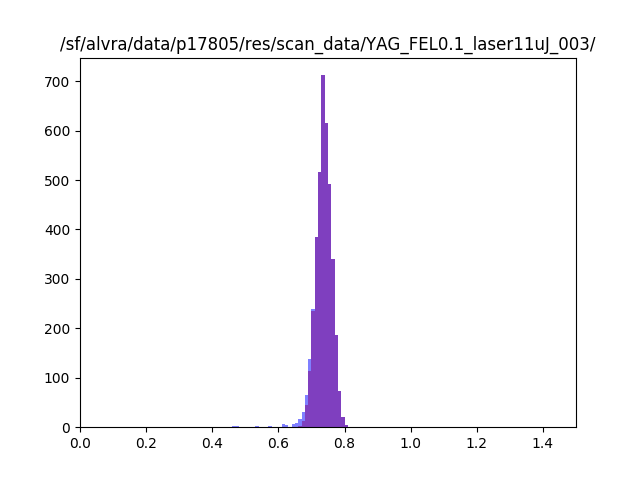

In [43]:
# Check if the condition on the intensity makes sense by looking at the total histogram. 

num_bins = 100
print ("Total shots=",Izero_total_1D.size,"// filtered=,",Izero_total_1D_filter.size)
plt.figure()
plt.hist(Izero_total_1D_filter, bins =np.arange(0,1.5,0.01), facecolor='red', alpha=0.5)
plt.hist(Izero_total_1D, bins =np.arange(0,1.5,0.01), facecolor='blue', alpha=0.5)
#plt.hist(Izero_pump_loop_filter, bins =np.arange(0,1.5,0.01), facecolor='blue', alpha=0.5)

#plt.hist(Izero_pump_loop, num_bins, facecolor='blue', alpha=0.5)
#plt.hist(Izero_pump_loop_filter, num_bins, facecolor='orange', alpha=0.5)
plt.xlim(0,1.5)
plt.title(DIR)

plt.show()

<IPython.core.display.Javascript object>


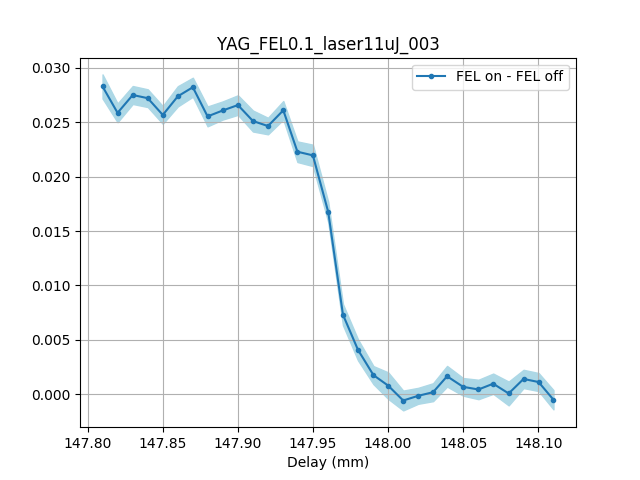

In [44]:
# Plot pump probe signal as a function of delay (stage mm)

#savedir = "/das/work/p17/p17569/Beamline/"
plt.figure()
plt.plot(Delay_mm, Laser_diff, label="FEL on - FEL off",marker='.')

low_err= Laser_diff - err_laser_diff
high_err= Laser_diff + err_laser_diff
plt.fill_between(np.squeeze(Delay_mm), low_err, high_err, color='lightblue')

plt.title(scan_name)
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.grid()
plt.show()
#plt.savefig(savedir + 'LAMcheck_026')


<IPython.core.display.Javascript object>


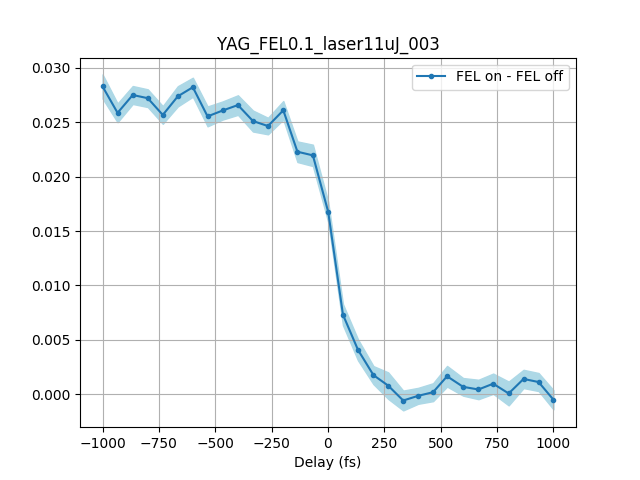

In [45]:
# Plot pump probe signal as a function of time (fs)

#savedir = "/das/work/p17/p17569/Beamline/"

Delay_ps = 2* (Delay_mm - 147.96)*3.333   # factor of 2 in delay due to the delay stage

plt.figure()
plt.plot((Delay_ps)*1000, Laser_diff, label="FEL on - FEL off",marker='.')   

low_err= Laser_diff - err_laser_diff
high_err= Laser_diff + err_laser_diff
plt.fill_between(np.squeeze((Delay_ps)*1000), low_err, high_err, color='lightblue')

plt.title(scan_name)
plt.xlabel("Delay (fs)")
plt.legend(loc="best")
plt.grid()
plt.show()
#plt.savefig('Timescan_7_diode')

In [46]:
#RUN THIS FOR THE FIT !!!

Delay_mm_toFit = Delay_mm.copy()
Delay_ps_toFit = Delay_ps.copy()
Laser_diff_toFit = Laser_diff.copy()

In [47]:
# Now fit with error funciton (defined above)
parameters,extras = curve_fit(errfunc, Delay_ps_toFit, Laser_diff_toFit, p0 = [0.02, 1, 0, 0.05])

print("Position t0 =",np.round(parameters[2],5)*1000,"fs")
print("Width =",np.abs(np.round(parameters[3],3))*1000,"fs")

Position t0 = 18.72 fs
Width = 244.0 fs


<IPython.core.display.Javascript object>


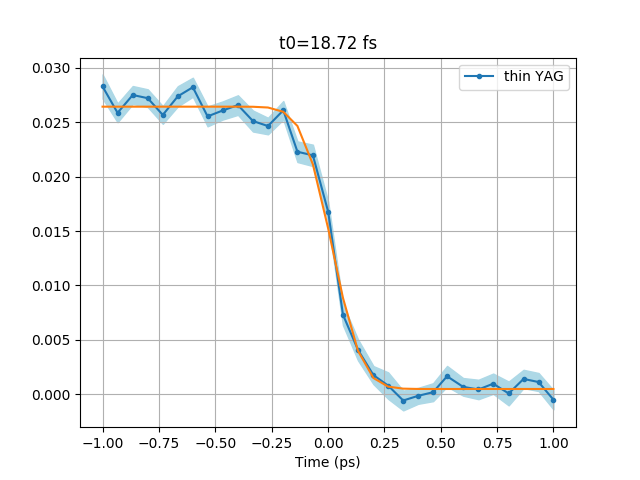

In [48]:
#... and the plot with the fit curve

#savedir = "/das/work/p17/p17569/Beamline/"

plt.figure()

plt.plot(Delay_ps_toFit, Laser_diff_toFit, label="thin YAG",marker='.')
plt.plot(Delay_ps_toFit, errfunc(Delay_ps_toFit,*parameters))

#low_err= signal_norm - err_signal_norm
#high_err= signal_norm + err_signal_norm

plt.fill_between(Delay_ps_toFit, low_err, high_err, color='lightblue')
plt.title('t0=' + str(np.round(parameters[2], 5)*1000) + ' fs' )
plt.grid()
plt.xlabel("Time (ps)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_YAG_007')

In [391]:
Laser_diff_1000_4 = Laser_diff.copy()
Delay_mm_1000_4 = Delay_mm.copy()
Delay_ps_1000_4 = Delay_ps.copy()

<IPython.core.display.Javascript object>


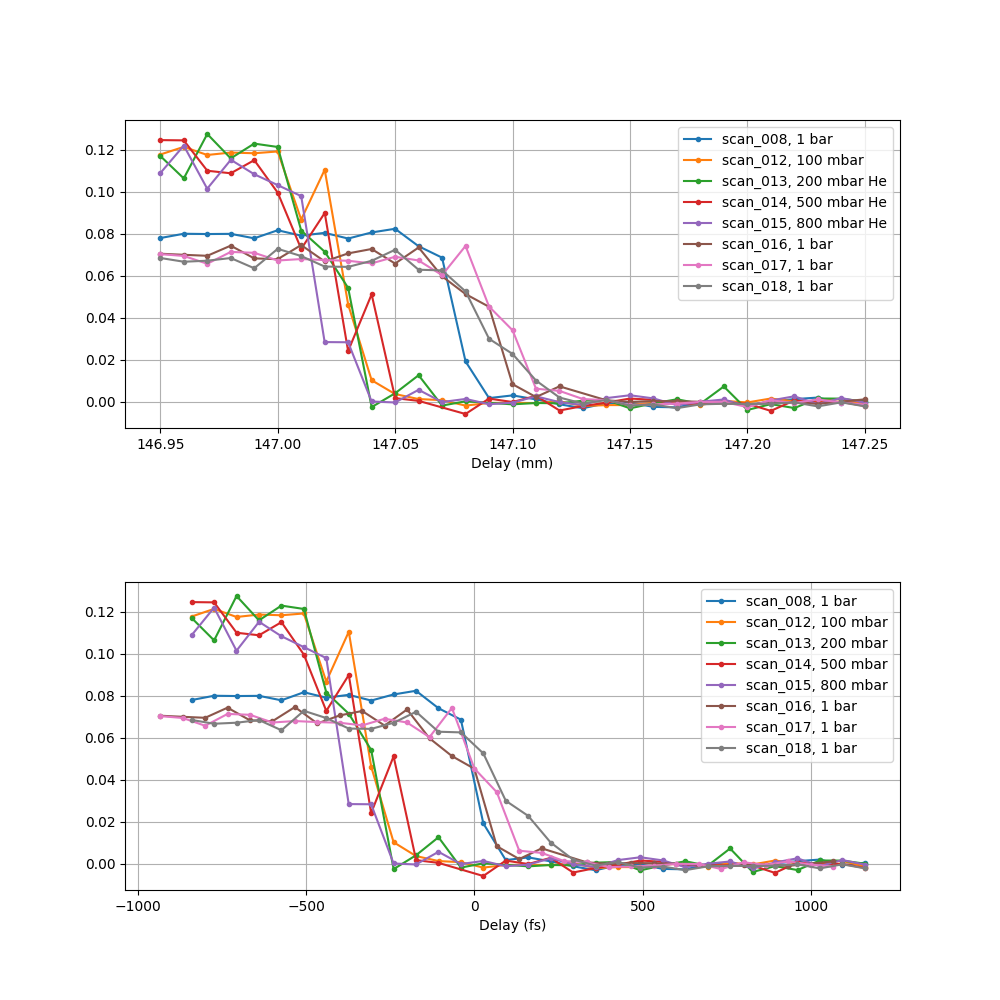

In [392]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.5)

plt.subplot(211)
plt.plot(Delay_mm_1000, Laser_diff_1000, label="scan_008, 1 bar",marker='.')
#plt.plot(Delay_mm_800, Laser_diff_800, label="scan_009, 800 mbar",marker='.')
#plt.plot(Delay_mm_500, Laser_diff_500, label="scan_010, 500 mbar",marker='.')
#plt.plot(Delay_mm_200, Laser_diff_200, label="scan_011, 200 mbar",marker='.')
plt.plot(Delay_mm_100, Laser_diff_100, label="scan_012, 100 mbar",marker='.')
plt.plot(Delay_mm_200He, Laser_diff_200He, label="scan_013, 200 mbar He",marker='.')
plt.plot(Delay_mm_500He, Laser_diff_500He, label="scan_014, 500 mbar He",marker='.')
plt.plot(Delay_mm_800He, Laser_diff_800He, label="scan_015, 800 mbar He",marker='.')
plt.plot(Delay_mm_1000_2, Laser_diff_1000_2, label="scan_016, 1 bar",marker='.')
plt.plot(Delay_mm_1000_3, Laser_diff_1000_3, label="scan_017, 1 bar",marker='.')
plt.plot(Delay_mm_1000_4, Laser_diff_1000_4, label="scan_018, 1 bar",marker='.')

#plt.plot(Delay_mm_toFit, errfunc(Delay_mm_toFit,*parameters))

#low_err= signal_norm - err_signal_norm
#high_err= signal_norm + err_signal_norm

#plt.fill_between(Delay_mm_toFit, low_err, high_err, color='lightblue')
#plt.title(np.round(parameters[2], 3) )
plt.grid()
plt.xlabel("Delay (mm)")
plt.legend(loc="best")

plt.subplot(212)

plt.plot(2*Delay_ps_1000*1000, Laser_diff_1000, label="scan_008, 1 bar",marker='.')
#plt.plot(2*Delay_ps_800*1000, Laser_diff_800, label="scan_009, 800 mbar",marker='.')
#plt.plot(2*Delay_ps_500*1000, Laser_diff_500, label="scan_010, 500 mbar",marker='.')
#plt.plot(2*Delay_ps_200*1000, Laser_diff_200, label="scan_011, 200 mbar",marker='.')
plt.plot(2*Delay_ps_100*1000, Laser_diff_100, label="scan_012, 100 mbar",marker='.')
plt.plot(2*Delay_ps_200He*1000, Laser_diff_200He, label="scan_013, 200 mbar",marker='.')
plt.plot(2*Delay_ps_500He*1000, Laser_diff_500He, label="scan_014, 500 mbar",marker='.')
plt.plot(2*Delay_ps_800He*1000, Laser_diff_800He, label="scan_015, 800 mbar",marker='.')
plt.plot(2*Delay_ps_1000_2*1000, Laser_diff_1000_2, label="scan_016, 1 bar",marker='.')
plt.plot(2*Delay_ps_1000_3*1000, Laser_diff_1000_3, label="scan_017, 1 bar",marker='.')
plt.plot(2*Delay_ps_1000_4*1000, Laser_diff_1000_4, label="scan_018, 1 bar",marker='.')
#plt.plot(Delay_mm_toFit, errfunc(Delay_mm_toFit,*parameters))


#low_err= signal_norm - err_signal_norm
#high_err= signal_norm + err_signal_norm

#plt.fill_between(Delay_mm_toFit, low_err, high_err, color='lightblue')
#plt.title(np.round(parameters[2], 3) )
plt.grid()
plt.xlabel("Delay (fs)")
plt.legend(loc="best")

plt.show()
#plt.savefig(savedir + 'scan_YAG_007')

<IPython.core.display.Javascript object>


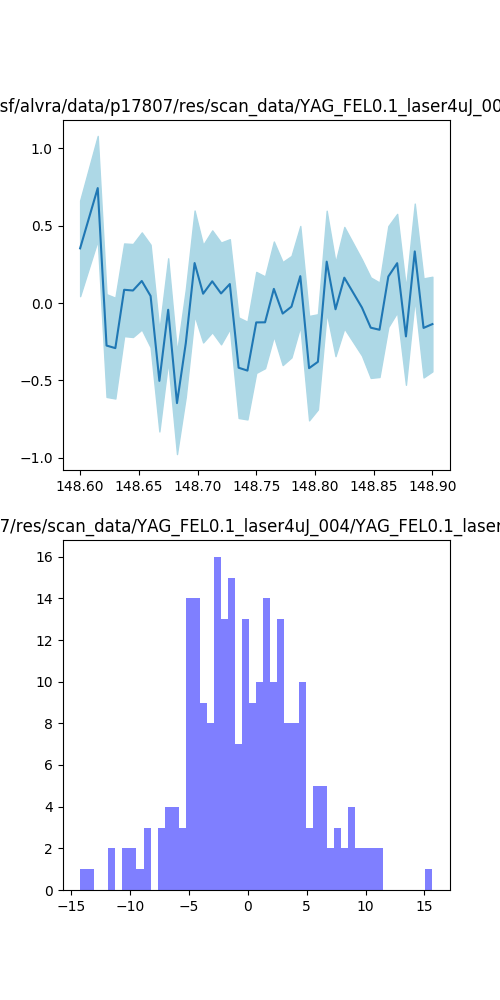

In [25]:
num_bins = 50

plt.figure(figsize=(5,10))

plt.subplot(211)
plt.plot(Delay_mm, BAM)
low_err = BAM - BAM_error
high_err = BAM + BAM_error
plt.fill_between(np.squeeze(Delay_mm), low_err, high_err, color='lightblue')
plt.title(DIR)

plt.subplot(212)
plt.hist(BAM_loop, num_bins, facecolor='blue', alpha=0.5)
plt.title(filename)

plt.show()

## Next cell  just to calculate time zero 

In [49]:
time_zero = 147.96      #this is in mm from the delay scans

desidered_delay = 6.310
#choose this in ps

delay_to_set = (100/(2*333))*desidered_delay + time_zero        #factor of 2 because of the delay stage

desidered_delay + time_zero
print ("To be at",desidered_delay,"ps, put the laser pump delay stage to",np.round(delay_to_set,4),"mm")

To be at 6.31 ps, put the laser pump delay stage to 148.9074 mm


In [74]:
offset_space = 45       # this is in um

offset_time = 2*(offset_space * 1e-6)/3e8/1e-15            #factor of 2 because of the delay stage, results in fs
print ("An offset of",offset_space,"um corresponds to an offset of",np.round(offset_time,4),"fs")

An offset of 45 um corresponds to an offset of 300.0 fs


In [3]:
offset_time = 5000      # this is in fs

offset_space = 3e8 * (offset_time * 1e-15)/2/1e-6          #factor of 2 because of the delay stage, results in um
print ("An offset of",offset_time,"fs corresponds to an offset of",np.round(offset_space,4),"um")

An offset of 5000 fs corresponds to an offset of 750.0 um


In [117]:
saveDir = "/das/work/p17/p17589/Gregor/"   # dest folder (needs to exist)
fn = str(saveDir + "yag_longscan_xy.h5")
hf = h5py.File(fn, 'w')
hf.create_dataset('Position_mm', data = Delay_mm)
hf.create_dataset('Laser_diff', data = Laser_diff)
hf.close()


In [115]:
saveDir

'das/work/p17/p17589/Gregor/'

In [126]:
1000 / 30

33.333333333333336